## Proyecto del módulo 2 se entregará y se presentará el día:
### - 18 de octubre (en la hora de clase).

## Asesoría para el proyecto los días:
### - 11 y 16 de octubre en la hora de clase.

#### Temas para el proyecto
1. Aplicación de montecarlos en el desarrollo de integrales dobles o triples o alguna aplicación de interés que se incurra en integrales y se tengan que solucionar para resolver diversos problemas. Recuerden todo esto resuelto usando montecarlo.
2. Aplicación de los fractales (el que desee puede replicar el ejemplo mostrado en el video de youtube que vimos en clase). También, pueden evaluar la posibilidad de poder generar paisajes, montañas usando fractales, entre otras aplicaciones de interés que encuentren.

# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [5]:
# Importamos librerías
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

# Sobre escribir el método de lectura de pandas-datareader por el de yahoo-finance
yf.pdr_override()

In [6]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.get_data_yahoo(tickers, start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    
    if len(tickers) == 1:
        closes = closes.to_frame().copy()
        closes.columns = [tickers]
    return closes

In [9]:
# Descargamos datos...
names = ['TSLA', 'GOOG']
start = '2018-01-01'
end = '2020-12-31'

precios = get_adj_closes(names, start, end)
precios.head()

[*********************100%***********************]  2 of 2 completed


,GOOG,TSLA
Date,,
2018-01-02,53.250000,21.368668
2018-01-03,54.124001,21.150000
2018-01-04,54.320000,20.974667
2018-01-05,55.111500,21.105333
2018-01-08,55.347000,22.427334


<Axes: xlabel='Date'>

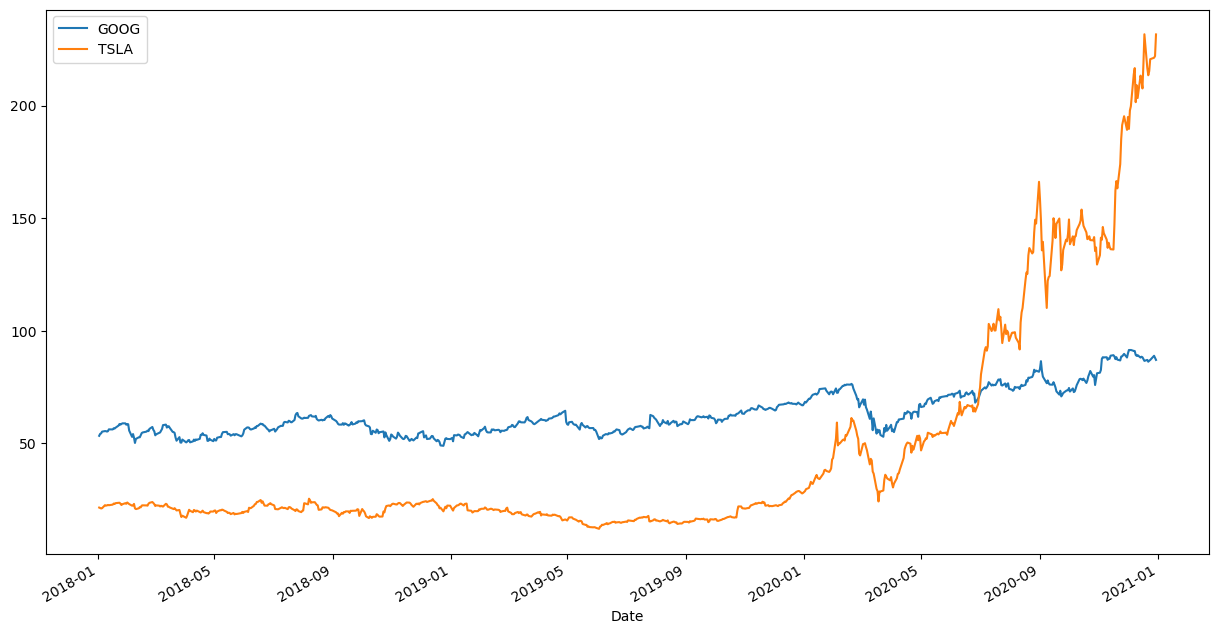

In [10]:
# Graficamos
precios.plot(figsize=(15,8))

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

<AxesSubplot:title={'center':'rendimientos logaritmicos'}, xlabel='Date'>

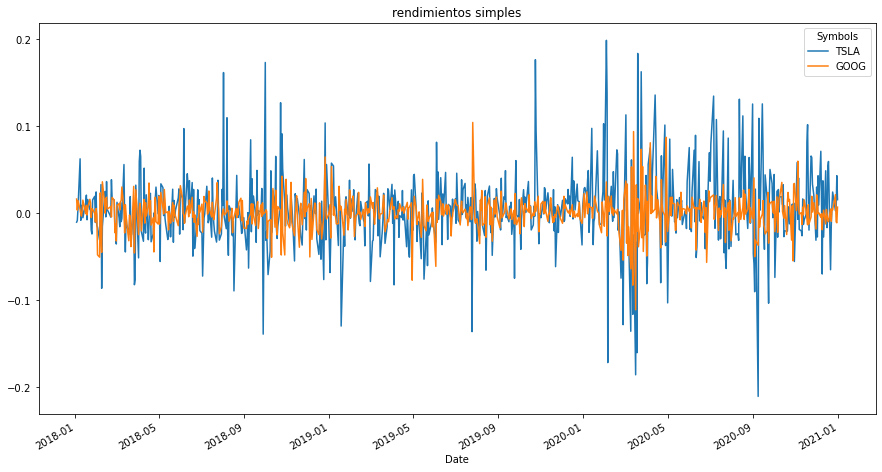

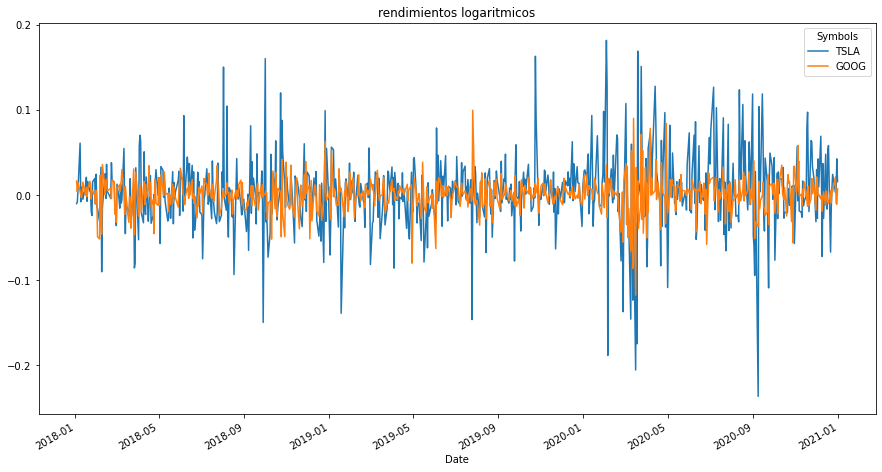

In [9]:
# Calcular rendimientos diarios y graficarlos
ret = precios.pct_change()
ret.plot(figsize=(15, 8), title='rendimientos simples')

ret2 = np.log(precios/precios.shift())
ret2.plot(figsize=(15, 8), title='rendimientos logaritmicos')


In [25]:
ret['GOOG'].mean()

0.0008475234546680837

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

array([[<AxesSubplot:title={'center':'TSLA'}>,
        <AxesSubplot:title={'center':'GOOG'}>]], dtype=object)

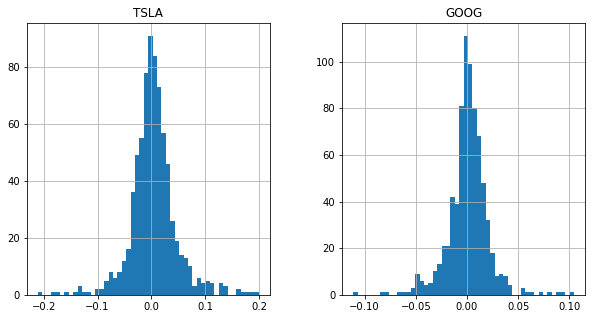

In [17]:
ret.hist(bins=50, figsize=(10,5))

In [26]:
# Calculamos media y desviación estándar
mu_TSLA = ret['TSLA'].mean()
mu_GOOG = ret['GOOG'].mean()

std_TSLA = ret['TSLA'].std()
std_GOOG = ret['GOOG'].std()

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2020, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2021 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

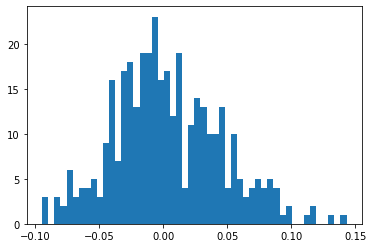

In [61]:
N = 365
plt.hist(std_TSLA * np.random.randn(N) + mu_TSLA, bins=50);

In [44]:
pd.DataFrame(std_TSLA * np.random.randn(N,9) + mu_TSLA, index=pd.date_range('19/10/2022', periods=N, freq='B')) \
    .mean(axis=1)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: Parsing '19/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


2022-10-19    0.003689
2022-10-20   -0.000506
2022-10-21   -0.027990
2022-10-24    0.015328
2022-10-25   -0.011030
                ...   
2026-08-12   -0.013275
2026-08-13   -0.000845
2026-08-14    0.005145
2026-08-17    0.006679
2026-08-18    0.007421
Freq: B, Length: 1000, dtype: float64

In [39]:
pd.date_range('19/10/2022', periods=50, freq='B').shape

(50,)

In [7]:
# Ayuda en la función np.random.randn
help(np.random.randn)  # Por defecto toma que mu = 0 y que std = 1

Help on built-in function randn:

randn(...) method of numpy.random.mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `standard_normal`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    .. note::
        New code should use the ``standard_normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    If positive int_like arguments are provided, `randn` generates an array
    of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1. A single float randomly sampled
    from the distribution is returned if no argument is provided.
 

In [45]:
# Función que simula varios escenarios de rendimientos diarios
def sim_rend(mu, std, ndays, nscen, start_date):
    
    # Generar el rango de fechas en las que se realizará la predicción (freq='B' días laborales)
    fechas = pd.date_range(start_date, periods=ndays, freq='B')
    
    # Generar la predicción asumiendo que los rendimientos siguen una distribución normal (gaussiana)
    datos = std*np.random.randn(ndays, nscen) + mu
    
    # Generar un dataframe (tabla) con los resultados
    rendimientos_simulados = pd.DataFrame(datos, index=fechas)
    
    return rendimientos_simulados

In [46]:
# Simulamos 100 escenarios para todo el 2021
ndays = 365
nscen = 100
start_date = '01/01/2021'

rend_simu_TSLA = sim_rend(mu_TSLA, std_TSLA, ndays, nscen, start_date)
rend_simu_TSLA

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2021-01-01,0.006354,-0.055981,0.058830,-0.054939,-0.096564,0.041379,-0.016143,-0.045280,0.012097,-0.011227,...,0.056649,0.012911,-0.040223,0.080052,0.042902,-0.013486,-0.027783,0.027980,0.078940,0.063299
2021-01-04,0.001808,-0.005816,-0.008873,-0.039816,0.055615,-0.001924,-0.045124,0.041894,0.031582,-0.000678,...,0.093397,0.027911,-0.004222,0.086741,-0.057011,0.119891,-0.062153,-0.012638,0.041281,-0.018730
2021-01-05,-0.096273,0.029245,0.017545,0.039446,0.024126,-0.088636,0.012629,0.010953,0.061963,-0.014328,...,0.067735,0.016945,-0.006791,0.009386,0.002948,-0.098741,-0.023848,0.052042,0.030905,-0.049951
2021-01-06,0.039556,0.025087,-0.021713,-0.005696,-0.029185,0.003455,0.007699,-0.038871,-0.045448,-0.009983,...,0.022532,-0.004307,0.063907,0.107235,0.012802,-0.009598,-0.021372,0.038163,0.010134,-0.029765
2021-01-07,0.071112,-0.003401,0.035581,-0.063152,-0.040378,0.074254,0.045817,0.014365,0.014117,0.064459,...,0.010647,-0.059601,0.076920,-0.039830,-0.002094,-0.028830,0.041746,-0.022052,0.014233,-0.000191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,-0.001097,-0.007223,-0.011058,-0.006487,0.023847,-0.049237,-0.004073,-0.033412,0.017424,-0.001548,...,-0.035244,0.023717,0.014346,-0.041297,-0.086265,0.024633,0.032726,-0.007083,0.011852,-0.043175
2022-05-23,-0.024185,0.052743,0.013640,0.009548,-0.012758,-0.031468,-0.031027,0.007080,0.108994,0.012503,...,0.064434,-0.010474,0.019051,0.051166,-0.002249,0.057795,0.007979,-0.030978,-0.003398,-0.014845
2022-05-24,0.016648,-0.009729,0.032318,0.081773,0.007140,0.041136,-0.056892,-0.012191,-0.037035,-0.012763,...,0.036765,0.015763,0.018266,0.018189,0.088092,-0.002538,-0.075447,-0.008974,-0.052801,-0.108941
2022-05-25,-0.053372,-0.100798,0.008002,-0.058221,-0.018620,0.042510,0.005612,-0.037629,0.037609,0.050114,...,-0.006533,0.020943,0.047237,0.012923,-0.029500,-0.016619,-0.020447,-0.018809,0.051551,0.055923


<AxesSubplot:>

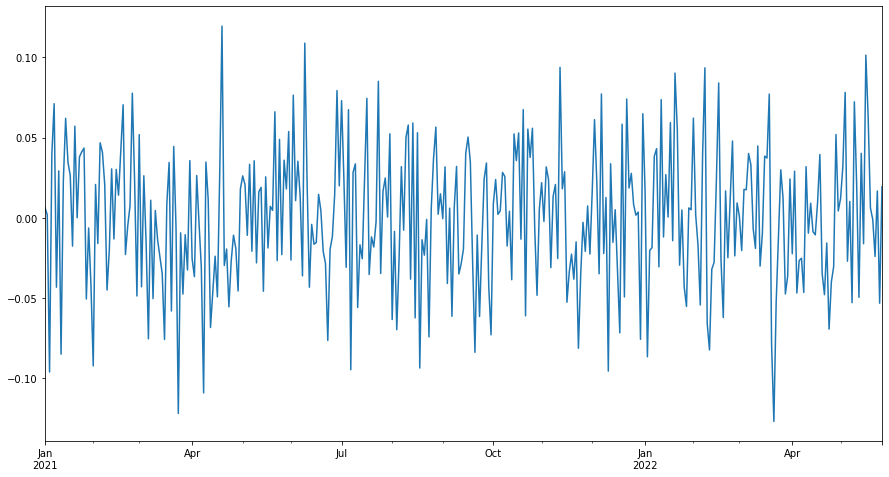

In [48]:
# Mostrar
rend_simu_TSLA.iloc[:, 0].plot(figsize=(15,8), legend=False)

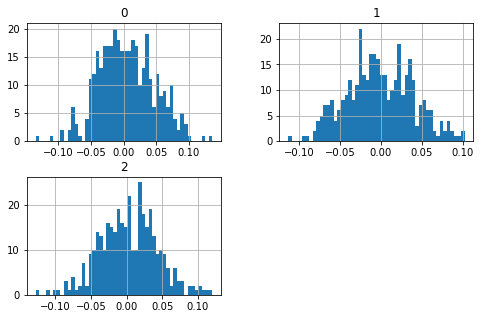

In [28]:
rend_simu_TSLA.iloc[:, 0:3].hist(bins=50, figsize=(8,5));

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:
> Recordar que:
> $$
R_t=\frac{p_t-p_{t-1}}{p_{t-1}} = \frac{p_t}{p_{t-1}} - 1 \longrightarrow p_t=p_{t-1}(R_t+1)
$$

Encontremos una posible solución a la anterior ecuación a diferencia **(resaltar importancia de rendimientos diarios)**:

$$\begin{align}
p_1&=p_{0}(R_0 +1)\\
p_{2}&=p_1(R_{1}+1)=p_{0}(R_0+1)(R_{1}+1)\\
&\vdots\\
p_{T}&=p_{0}(R_0+1)\cdots(R_{T}+1).
\end{align}$$

tenemos que $p_{T}=p_{0}(R_0+1)\cdots(R_{k}+1)$, donde $p_{0}$ es el último precio reportado del activo subyacente que estamos analizando.

In [65]:
(rend_simu_TSLA + 1).cumprod()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2021-01-01,1.006354,0.944019,1.058830,0.945061,0.903436,1.041379,0.983857,0.954720,1.012097,0.988773,...,1.056649,1.012911,0.959777,1.080052,1.042902,0.986514,0.972217,1.027980,1.078940,1.063299
2021-01-04,1.008173,0.938529,1.049435,0.907432,0.953680,1.039376,0.939461,0.994716,1.044061,0.988103,...,1.155337,1.041182,0.955725,1.173737,0.983445,1.104788,0.911791,1.014988,1.123480,1.043384
2021-01-05,0.911113,0.965976,1.067848,0.943226,0.976689,0.947250,0.951325,1.005611,1.108754,0.973945,...,1.233594,1.058825,0.949234,1.184754,0.986344,0.995700,0.890046,1.067810,1.158201,0.991266
2021-01-06,0.947153,0.990210,1.044662,0.937853,0.948185,0.950523,0.958649,0.966522,1.058364,0.964223,...,1.261389,1.054265,1.009897,1.311801,0.998971,0.986144,0.871025,1.108561,1.169938,0.961760
2021-01-07,1.014507,0.986842,1.081833,0.878626,0.909899,1.021103,1.002572,0.980406,1.073304,1.026375,...,1.274819,0.991430,1.087579,1.259551,0.996879,0.957713,0.907386,1.084115,1.186590,0.961577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,0.672761,1.311501,1.228494,1.520614,2.736014,2.280938,1.106742,1.356695,5.984672,4.293335,...,1.935823,4.383412,1.825652,4.095442,2.213248,4.577990,17.254381,6.761980,3.303719,3.308107
2022-05-23,0.656491,1.380674,1.245251,1.535134,2.701108,2.209162,1.072403,1.366300,6.636968,4.347013,...,2.060556,4.337502,1.860433,4.304987,2.208270,4.842574,17.392050,6.552507,3.292491,3.258999
2022-05-24,0.667420,1.367241,1.285495,1.660666,2.720393,2.300039,1.011392,1.349643,6.391169,4.291533,...,2.136312,4.405873,1.894416,4.383291,2.402801,4.830284,16.079878,6.493702,3.118644,2.903961
2022-05-25,0.631798,1.229426,1.295782,1.563979,2.669739,2.397814,1.017067,1.298857,6.631537,4.506598,...,2.122355,4.498144,1.983903,4.439937,2.331919,4.750007,15.751088,6.371563,3.279413,3.066358


Con los rendimientos, calculamos los precios de cierre...

In [66]:
# Obtenemos los precios. Transformar los rendimientos simulados del 2021 a precios de acción simulados del 2021.
precios_simulados_TSLA = precios['TSLA'][-1]*(1+rend_simu_TSLA).cumprod()
precios_simulados_TSLA

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2021-01-01,236.717821,222.055403,249.061618,222.300378,212.509144,244.956698,231.426102,224.572306,238.068854,232.582512,...,248.548561,238.260240,225.761877,254.053454,245.314786,232.051119,228.688162,241.804855,253.791860,250.112746
2021-01-04,237.145777,220.763982,246.851708,213.449237,224.327825,244.485385,220.983165,233.980483,245.587445,232.424935,...,271.762188,244.910282,224.808742,276.090417,231.329163,259.871987,214.474437,238.748966,264.268643,245.428153
2021-01-05,214.315071,227.220126,251.182789,221.868856,229.740068,222.815239,223.773917,236.543179,260.804869,229.094657,...,290.169995,249.060383,223.281983,278.681667,232.011111,234.211913,209.359673,251.173869,272.435784,233.168799
2021-01-06,222.792586,232.920387,245.728944,220.605013,223.035178,223.585113,225.496708,227.348481,248.951820,226.807668,...,296.708184,247.987663,237.551356,308.566176,234.981362,231.964005,204.885295,260.759395,275.196659,226.228475
2021-01-07,238.635771,232.128288,254.472287,206.673294,214.029377,240.187296,235.828334,230.614433,252.466243,241.427449,...,299.867275,233.207396,255.823850,296.275853,234.489311,225.276512,213.438417,255.009230,279.113621,226.185239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,158.249105,308.495686,288.970556,357.683929,643.574297,536.529726,260.331560,319.126237,1407.734486,1009.892631,...,455.350766,1031.080676,429.436051,963.343394,520.607478,1076.850104,4058.633021,1590.575449,777.111667,778.143858
2022-05-23,154.421914,324.766744,292.912104,361.099234,635.363536,519.646432,252.254130,321.385517,1561.169774,1022.518920,...,484.690891,1020.281589,437.617127,1012.633465,519.436610,1139.086414,4091.015802,1541.302453,774.470688,766.592635
2022-05-24,156.992735,321.606991,302.378423,390.627307,639.899923,541.022864,237.902928,317.467575,1503.352000,1009.468620,...,502.510470,1036.364201,445.610833,1031.052336,565.194843,1136.195443,3782.362455,1527.470102,733.577924,683.079287
2022-05-25,148.613655,289.189564,304.798071,367.884446,627.984799,564.021728,239.237941,305.521555,1559.892140,1060.056936,...,499.227366,1058.068491,466.660231,1044.376680,548.521672,1117.312470,3705.023271,1498.740365,771.394541,721.278825


<AxesSubplot:>

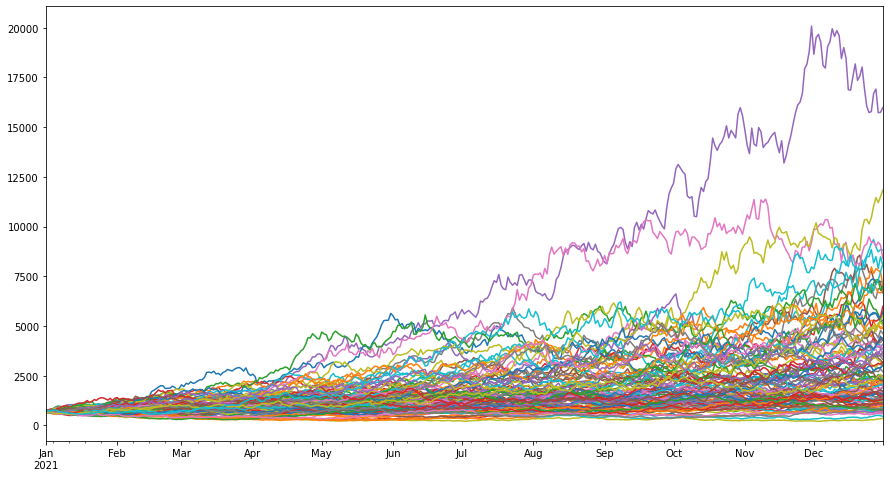

In [12]:
# Graficar
precios_simulados_TSLA.plot(figsize=(15, 8), legend=False)

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [67]:
# Umbral de 110% del ultimo precio
umbral = (1 + 0.1)*(precios['TSLA'][-1])

# Fechas
dates = precios_simulados_TSLA.index

In [77]:
TF = precios_simulados_TSLA>=umbral
TF


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2021-01-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-01-04,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,True,False,False,True,False
2021-01-05,False,False,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,False,False,True,False
2021-01-06,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,True,False
2021-01-07,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2022-05-23,False,True,True,True,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2022-05-24,False,True,True,True,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2022-05-25,False,True,True,True,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True


<AxesSubplot:>

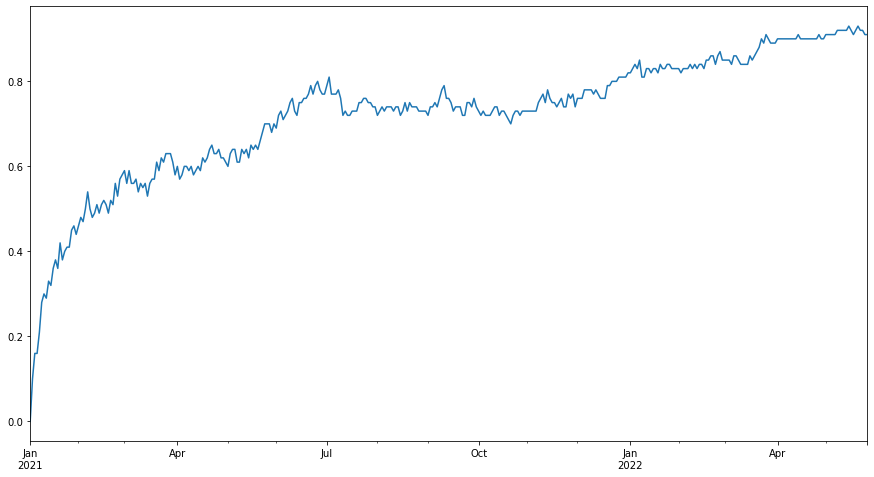

In [78]:
# Comparar cada escenario en cada fecha
TF = precios_simulados_TSLA>=umbral

# Sumamos para cada fecha y dividimos entre el número de escenarios
prob = TF.sum(axis=1)/nscen

# Gráfico de probabilidad
prob.plot(figsize=(15, 8), legend=False)

In [33]:
# Descargamos datos...
# Instrumento: 
names = ['TSLA']

# Fechas de interés (inicio y fin): 
start = '01/01/2021'
end = '23/11/2021'

# Función DataReader
precios_reales = get_close(names, start, end)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/pandas_datareader/_utils.py:37: UserWarning: Parsing '23/11/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  end = to_datetime(end)


<AxesSubplot:xlabel='Date'>

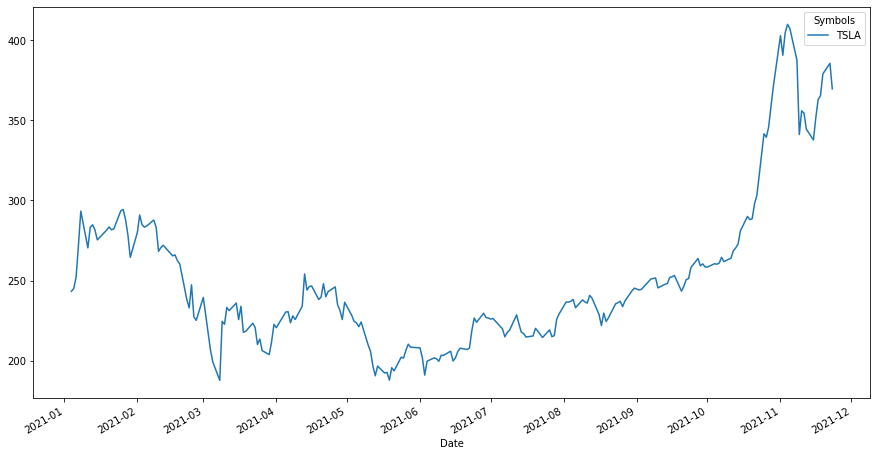

In [34]:
precios_reales.plot(figsize=(15, 8))

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

## Actividad
Siguiendo un procedimiento similar al realizado para los rendimientos diarios, encontrar los expresión matemática que permite simular precios por medio de la simulación de rendimientos logarítmicos. Recordar cuál es la expresión para cualcular rendimientos logarítmicos:
$$
r_t =\ln\left(\frac{S_t}{S_{t-1}}\right)
$$
> Pista: Despejar $S_t$ en función de $S_{t-1}$

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Cristian Camilo Zapata Zuluaga.
</footer>